In [56]:
!pip install pandas nltk scikit-learn openai python-dotenv networkx matplotlib

In [57]:
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np

In [58]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

In [78]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4-turbo', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [59]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [76]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg['List of triplets'])

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [74]:
# Build a knowledge from a user input
input = "Before GPT-4o, users could interact with ChatGPT using Voice Mode, which operated with three separate models. GPT-4o will integrate these capabilities into a single model that's trained across text, vision, and audio. This unified approach ensures that all inputs—whether text, visual, or auditory—are processed cohesively by the same neural network."
kg = build_knowledge_graph(input)
print(kg)

{'List of triplets': [['users', 'could interact with', 'ChatGPT'], ['ChatGPT', 'using', 'Voice Mode'], ['Voice Mode', 'operated with', 'three separate models'], ['GPT-4o', 'will integrate', 'capabilities'], ['GPT-4o', 'trained across', 'text'], ['GPT-4o', 'trained across', 'vision'], ['GPT-4o', 'trained across', 'audio'], ['approach', 'ensures', 'all inputs'], ['inputs', 'processed cohesively by', 'same neural network']]}


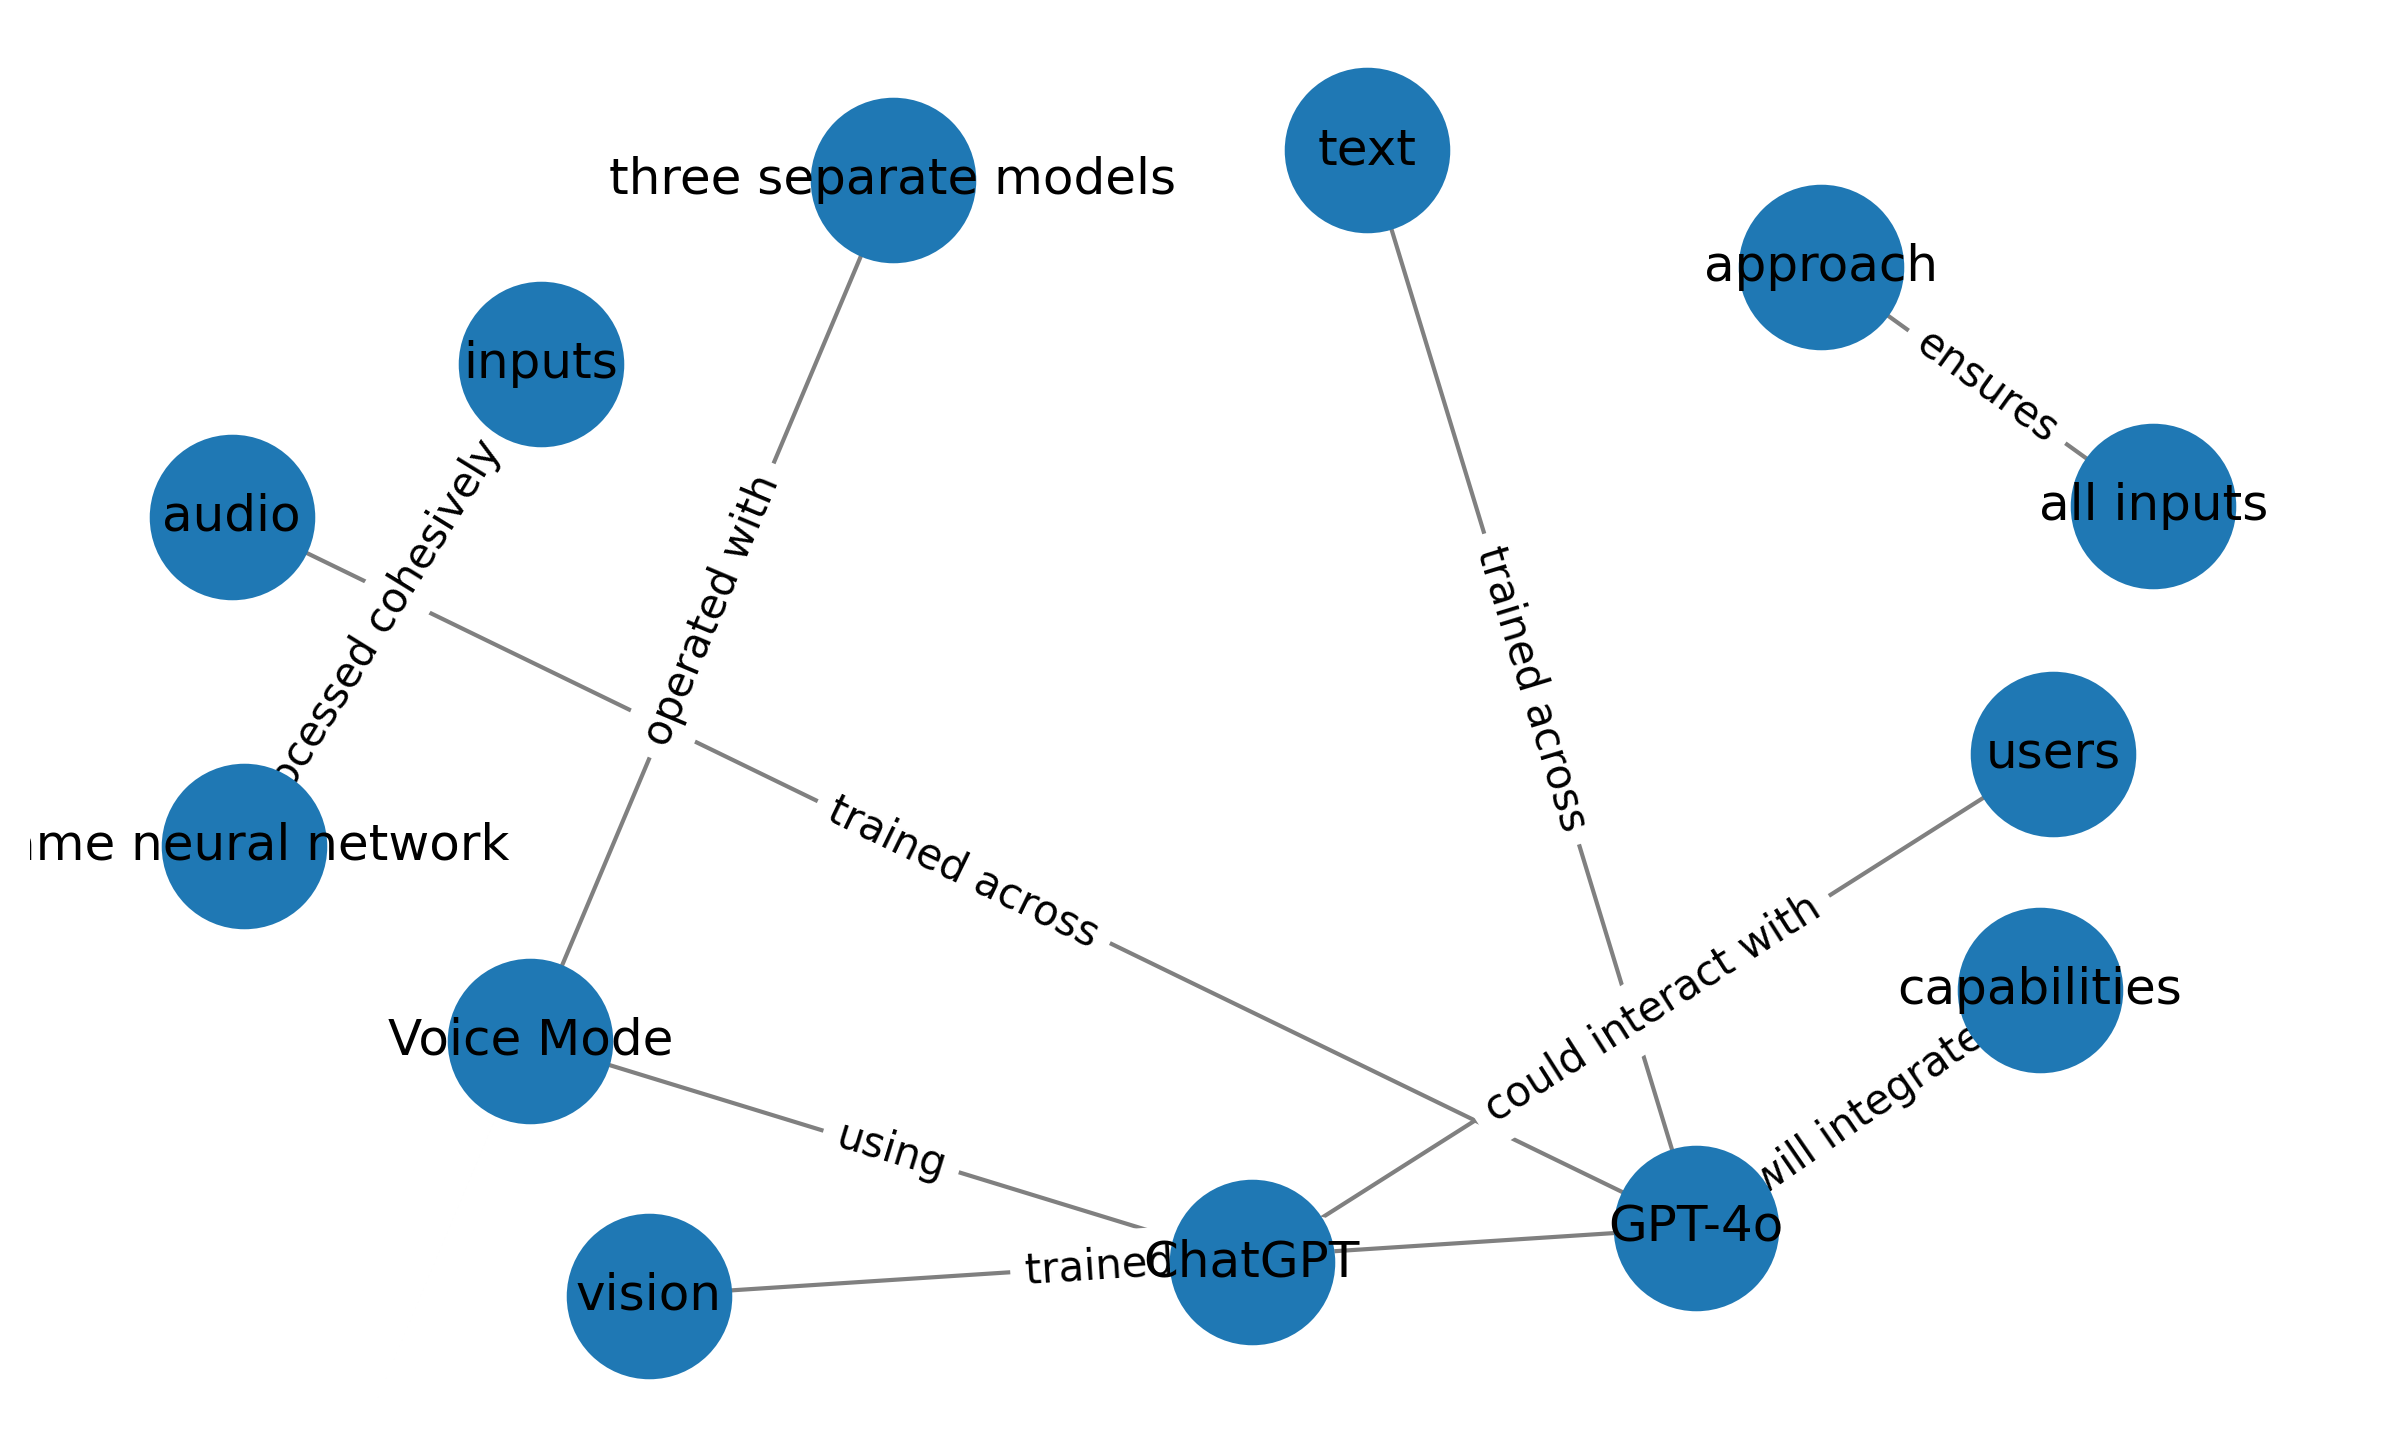

In [77]:
plot_graph(kg)